In [2]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torchvision import transforms
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


In [3]:
transform_pipeline = transforms.Compose([
            transforms.Resize([512, 512]),
            transforms.ToTensor()
    ])

In [4]:
food_train_and_valid_datasets = datasets.Food101(root="./data", split="train", download=True, transform=transform_pipeline)
food_test_datasets = datasets.Food101(root="./data", split="test", download=True, transform=transform_pipeline)
len(food_train_and_valid_datasets)

75750

In [5]:
food_train_datasets, food_valid_datasets = random_split(food_train_and_valid_datasets,[64388, 11362])

food_train_dataloader = DataLoader(dataset=food_train_datasets, batch_size=4, shuffle=True) 
food_valid_dataloader = DataLoader(dataset=food_valid_datasets, batch_size=4, shuffle=True) 
food_test_dataloader = DataLoader(dataset=food_test_datasets, batch_size=4, shuffle=True) 


In [6]:
train_features, train_labels = next(iter(food_train_dataloader))


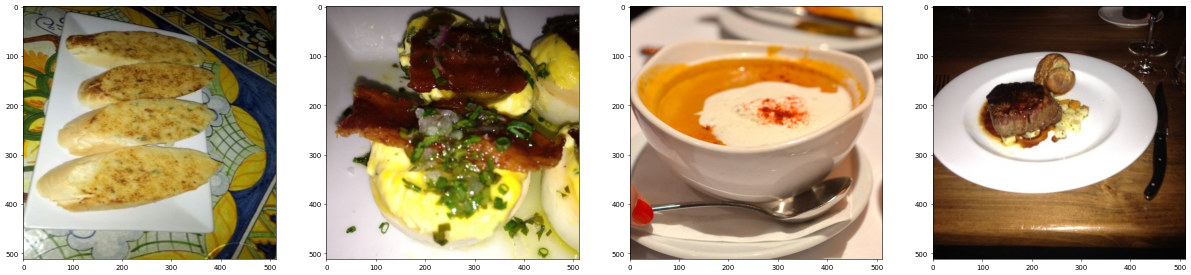

In [7]:
plt.figure(figsize=(30,16), dpi=50)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(train_features[i].numpy().transpose((1, 2, 0)))
        
plt.show()

In [8]:

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    def forward(self, x):
        out = self.layer(x) + self.shortcut(x)
        return nn.ReLU(inplace=True)(out)
class ResNet18(nn.Module): 
    def __init__(self, num_classes=101): 
        super(ResNet18, self).__init__()
        self.in_channels = 64 
        self.resnet18 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            self._make_layer(BasicBlock, 64, 2, stride=1),
            self._make_layer(BasicBlock, 128, 2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
  
    def forward(self, x): 
        return self.resnet18(x) 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=101).to(device)  # Food101 has 101 classes

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
error = []
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(food_train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        error.append(loss.item())
        running_loss += loss.item()
        print(loss.item())
    print(f'Epoch {epoch} loss: {running_loss / len(food_train_dataloader)}')

4.323544025421143
4.8451948165893555
4.065545082092285
4.280838966369629
4.643855571746826
4.336361408233643
4.035952568054199
4.438283920288086
4.110748767852783
4.538466453552246
4.813669681549072
4.088744163513184
4.228839874267578
4.3367533683776855
3.8496763706207275
5.106131553649902
4.62184476852417
4.021990776062012
4.492346286773682
4.365075588226318
4.575211524963379
3.760141372680664
5.289493560791016
4.24648904800415
4.385411262512207
5.17675256729126
4.754332542419434
4.726926326751709
4.2730512619018555
4.683228969573975
4.021939277648926
4.352868556976318
4.405034065246582
4.027203559875488
4.151810646057129
4.592388153076172
4.4746928215026855
4.203523635864258
4.232537269592285
4.128474235534668
4.051278114318848
4.320486545562744
4.999018669128418
4.577453136444092
2.983550786972046
4.913969993591309
4.767106533050537
4.026391983032227
4.429215908050537
4.706609725952148
4.695795059204102
3.9802072048187256
4.67111349105835
3.64870285987854
4.885119438171387
4.0924396

KeyboardInterrupt: 